In [138]:
#Load dataset
from  models.vgg import vgg19
import torch
from datasets.crowd_sh_pl import Crowd
from torch.utils.data import DataLoader
import os
from torch.utils.data.dataloader import default_collate


def train_collate(batch):
    transposed_batch = list(zip(*batch))
    images = torch.stack(transposed_batch[0], 0)
    points = transposed_batch[1]  # the number of points is not fixed, keep it as a list of tensor
    targets = transposed_batch[2]
    st_sizes = torch.FloatTensor(transposed_batch[3])
    return images, points, targets, st_sizes



path = r'C:\Users\mahdi\Desktop\SASNet_ROOT\Bayseian\Bayesian-Crowd-Counting-master\models\1029-162400\best_model.pth'
device = torch.device("cuda")
model = vgg19()
model.to(device)
model.load_state_dict(torch.load(path,device))

data_dir = r'C:\Users\mahdi\Desktop\SASNet_ROOT\SHA_processed\train'
crop_size = 512
downsample_ratio = 8
is_gray = False
batch_size = 1

datasets = {x: Crowd(os.path.join(data_dir, x),
                crop_size,
                downsample_ratio,
                is_gray, x) for x in ['train', 'val']}

dataloaders = {x: DataLoader(datasets[x],
                            collate_fn=(train_collate
                                        if x == 'train' else default_collate),
                            batch_size=(batch_size
                            if x == 'train' else 1),
                            shuffle=(True if x == 'train' else False),
                            num_workers=8,
                            pin_memory=(True if x == 'train' else False))
                for x in ['train', 'val']}



In [139]:
#Predict all the images in the dataset
epoch_res=[]
out_model=[]
keypoints_list=[]
imgs=[]
for inputs,keypoints, count, name in dataloaders['val']:
    inputs = inputs.to(device)
    # inputs are images with different sizes
    assert inputs.size(0) == 1, 'the batch size should equal to 1 in validation mode'
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        res = count[0].item() - torch.sum(outputs).item()
        epoch_res.append(res)
        out_model.append(outputs)
        imgs.append(inputs)
        keypoints_list.append(keypoints)

C:\Users\mahdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\functional.py:3253: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


In [141]:
#Configurations of the gussian density map

import numpy as np
import os

from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
from scipy.spatial import KDTree

import torch

def gaussian_filter_density(gt):
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, 2, mode='constant')
    return density

import cv2

def keypoint2densitymap(keypoints, img_size, pm_size):
    gt_pm = np.zeros((int(img_size[0]/8),int(img_size[1]/8)))
    gt_pm[np.clip((keypoints[:,1]/8).astype(np.int),0,int(img_size[0]/8-1)),np.clip((keypoints[:,0]/8).astype(np.int),0,int(img_size[1]/8-1))]=1
    gt_dm = gaussian_filter_density(gt_pm)
    gt_dm = cv2.resize(gt_dm, (pm_size[1],pm_size[0]), interpolation=cv2.INTER_CUBIC)
    return gt_dm



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


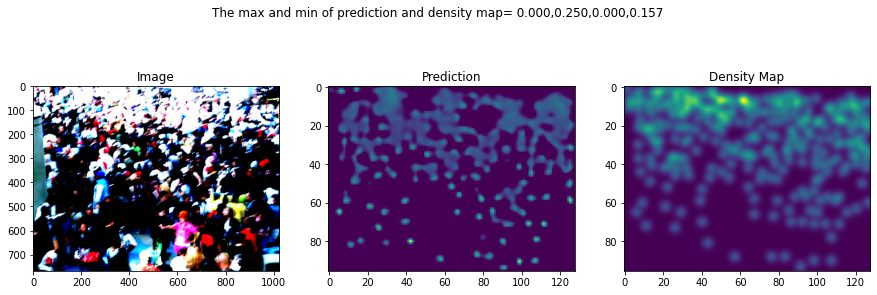

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


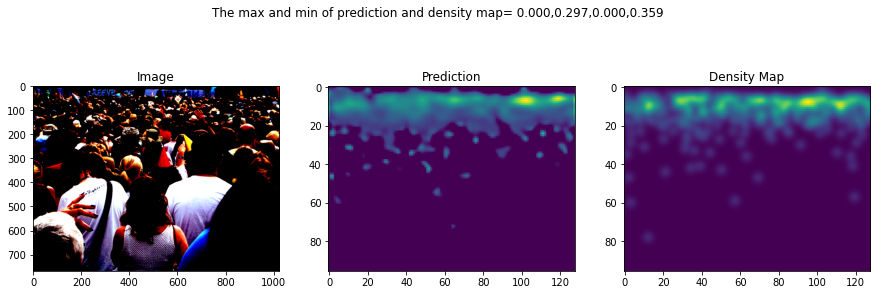

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


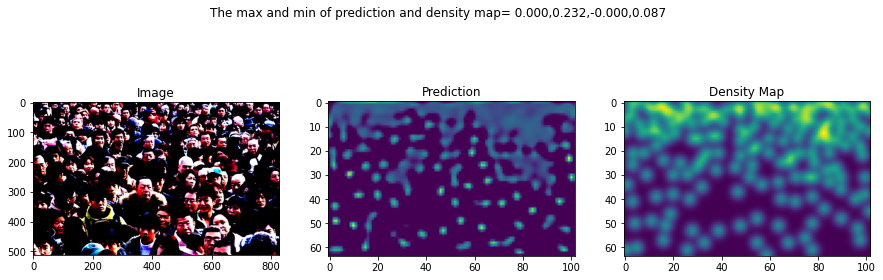

In [144]:
#Make random predictions
import numpy as np
for ii in range(3):
    idx = np.random.randint(0,len(imgs))
    pm = out_model[idx][0].cpu().detach().numpy()[0]
    dm = keypoint2densitymap(keypoints_list[idx][0].cpu().detach().numpy(),imgs[idx][0][0].shape,pm.shape)
    #Create a figure with three subplots
    fig, axs = plt.subplots(1,3,figsize=(15,5))
    axs[0].imshow(imgs[idx][0].cpu().detach().numpy().transpose(1,2,0))
    axs[1].imshow(pm)
    axs[2].imshow(dm)
    #Lable the subplots
    axs[0].set_title('Image')
    axs[1].set_title('Prediction')
    axs[2].set_title('Density Map')
    #Add title to the figure
    fig.suptitle('The max and min of prediction and density map= %0.3f,%0.3f,%0.3f,%0.3f'%(np.min(pm),np.max(pm),np.min(dm),np.max(dm)))
    plt.show()


In [128]:
#Load density maps
#New data loader
#Save the density maps

data_dir = r'C:\Users\mahdi\Desktop\SASNet_ROOT\SHA_AE\train'
crop_size = 512
downsample_ratio = 8
is_gray = False
batch_size = 1

datasets = {x: Crowd(os.path.join(data_dir, x),
                crop_size,
                downsample_ratio,
                is_gray, x) for x in ['train', 'val']}

dataloaders = {x: DataLoader(datasets[x],
                            collate_fn=(train_collate
                                        if x == 'train' else default_collate),
                            batch_size=(batch_size
                            if x == 'train' else 1),
                            shuffle=(True if x == 'train' else False),
                            num_workers=8,
                            pin_memory=(True if x == 'train' else False))
                for x in ['train', 'val']}


keypoints_list=[]
dm_list = []
ii=0
for inputs,keypoints, count, name in dataloaders['val']:
    inputs = inputs.to(device)
    # inputs are images with different sizes
    assert inputs.size(0) == 1, 'the batch size should equal to 1 in validation mode'
    with torch.set_grad_enabled(False):
        out_model = model(inputs)
        pm = out_model[0].cpu().detach().numpy()[0]
        dm = keypoint2densitymap(keypoints[0].cpu().detach().numpy(),inputs[0][0].shape,pm.shape)
        keypoints_list.append(keypoints)
        dm = (dm-np.min(dm))/(np.max(dm)-np.min(dm))
        np.save(os.path.join(r"C:\Users\mahdi\Desktop\SASNet_ROOT\SHA_AE",'dm_%s.npy'%ii),dm)
        ii+=1
        dm_list.append(dm)



RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[1, 3, 768, 1024] to have 1 channels, but got 3 channels instead

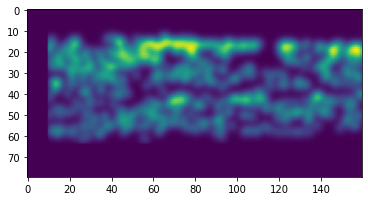

torch.Size([1, 1, 96, 144])
1.0
torch.Size([1, 1, 96, 128])
1.0
torch.Size([1, 1, 80, 128])
1.0
torch.Size([1, 1, 96, 144])
1.0
torch.Size([1, 1, 112, 144])
1.0
torch.Size([1, 1, 112, 144])
1.0
torch.Size([1, 1, 112, 144])
1.0
torch.Size([1, 1, 96, 144])
1.0
torch.Size([1, 1, 80, 96])
1.0
torch.Size([1, 1, 80, 96])
1.0
torch.Size([1, 1, 80, 112])
1.0
torch.Size([1, 1, 80, 128])
1.0
torch.Size([1, 1, 96, 144])
1.0
torch.Size([1, 1, 80, 144])
1.0
torch.Size([1, 1, 80, 112])
1.0
torch.Size([1, 1, 144, 144])
1.0
torch.Size([1, 1, 80, 128])
1.0
torch.Size([1, 1, 96, 144])
1.0
torch.Size([1, 1, 96, 144])
1.0
torch.Size([1, 1, 80, 96])
1.0
torch.Size([1, 1, 80, 96])
1.0
torch.Size([1, 1, 80, 96])
1.0
torch.Size([1, 1, 80, 96])
1.0
torch.Size([1, 1, 80, 80])
1.0
torch.Size([1, 1, 112, 144])
1.0
torch.Size([1, 1, 112, 144])
1.0
torch.Size([1, 1, 96, 80])
1.0
torch.Size([1, 1, 96, 144])
1.0
torch.Size([1, 1, 112, 144])
1.0
torch.Size([1, 1, 96, 80])
1.0
torch.Size([1, 1, 80, 112])
1.0
torch.Size

In [129]:
#Pytorch autoencoder model for density map prediction
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
from torch.utils.tensorboard import SummaryWriter
#Pytorch dataloarder from directory of numpy arrays


class AE_Dataset(torch.utils.data.Dataset):


      'Characterizes a dataset for PyTorch'
      def __init__(self, directory):
            'Initialization'
            self.paths = glob(directory+'/*.npy')
            self.transform = transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.RandomHorizontalFlip(),
                              transforms.ToTensor()])
                              

      def __len__(self):
            'Denotes the total number of samples'
            return len(self.paths)



      def __getitem__(self, index):
            'Generates one sample of data'
            dm = np.load(self.paths[index])
            h = dm.shape[0]
            w = dm.shape[1]
            h_padding = h%16
            w_padding = w%16
            dm = np.pad(dm,((0,16-h_padding),(0,16-w_padding)),'constant')
            return self.transform(dm)


params = {'batch_size': 1,
          'shuffle': True}

dm_loader = AE_Dataset(r'C:\Users\mahdi\Desktop\SASNet_ROOT\SHA_AE')
dm = dm_loader.__getitem__(10)
plt.imshow(dm[0])
plt.show()

AE_dataloader = DataLoader(dm_loader,batch_size=1,shuffle=True)

for epoch in range(1):  # loop over the dataset multiple times
      for pic in AE_dataloader:
            dm = pic
            print(pic.size())
            print(np.max(dm.detach().numpy()))
# dmb = AE_dataloader.batch_sampler


In [130]:
#Autoencoder atchitecture
import time
class AE(nn.Module):
      def __init__(self):
            super(AE, self).__init__()
            self.encoder = nn.Sequential(
                  nn.Conv2d(1, 64, 3, stride=2,padding=1),
                  nn.ReLU(True),
                  nn.Conv2d(64, 128, 3, stride=2,padding=1),
                  nn.ReLU(True),
                  nn.Conv2d(128, 16, 3, stride=2,padding=1),
                  nn.ReLU(True),
                  nn.Conv2d(16, 3, 3, stride=2,padding=1),
                  nn.ReLU(True))
                  

            self.decoder = nn.Sequential(
            
                  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                  nn.Conv2d(3, 16, 3, stride=1,padding=1),
                  nn.ReLU(True),
                  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                  nn.Conv2d(16, 128, 3, stride=1,padding=1),
                  nn.ReLU(True),
                  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                  nn.Conv2d(128, 64, 3, stride=1,padding=1),
                  nn.ReLU(True),
                  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                  nn.Conv2d(64, 1, 3, stride=1,padding=1),                  
                  nn.Sigmoid())

      def forward(self, x):
            x = self.encoder(x)
            x = self.decoder(x)
            return x

model=AE()
tb_writer = SummaryWriter(r"C:\Users\mahdi\Desktop\SASNet_ROOT\Bayseian\AE\logs/model%0.f"%time.time(),flush_secs=1)
print("tensorboard is running")
print(model)
tb_writer.add_graph(model, dm)
tb_writer.close()

tensorboard is running
AE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode=bilinear)
    (1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Upsample(scale_factor=2.0, mode=bilinear)
    (4): Conv2d(16, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Upsample(scale_factor=2.0, mode=bilinear)
    (7): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Upsample(scale_factor=2.0, mode=bil

In [131]:
# Validation using MSE Loss function
loss_function = torch.nn.L1Loss()
  
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-8)

tb_writer = SummaryWriter(r"C:\Users\mahdi\Desktop\SASNet_ROOT\Bayseian\AE\logs/{}".format(time.time()),flush_secs=1)
epochs = 200
outputs = []
losses = []
for epoch in range(epochs):
    for image in AE_dataloader:          
        # Output of Autoencoder
        reconstructed = model(image)
          
        # Calculating the loss function
        loss = loss_function(reconstructed, image)
          
        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
          
        #Coverting the loss tensor to numpy array
        loss = loss.detach().numpy()
        losses.append(loss)

    epoch_loss = np.mean(np.array(losses))
    tb_writer.add_scalar('Loss', epoch_loss, epoch)
    outputs.append((epochs, image, reconstructed))

# save the weights of the model
torch.save(model.state_dict(), r"C:\Users\mahdi\Desktop\SASNet_ROOT\Bayseian\AE\model.pth")
  

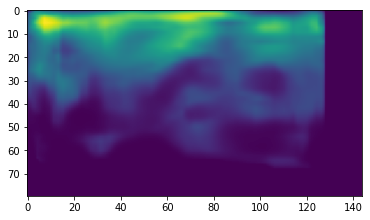

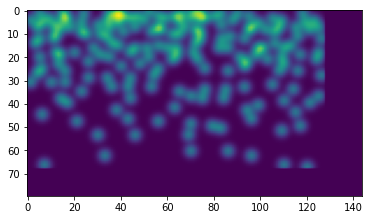

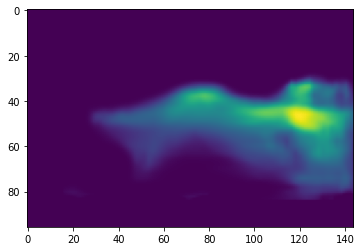

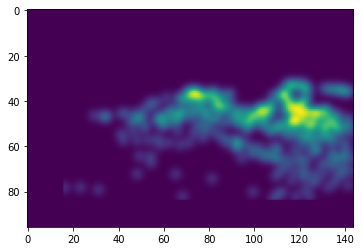

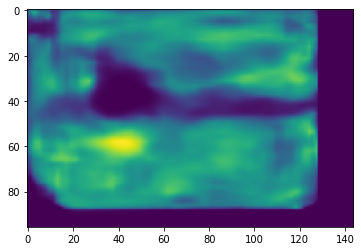

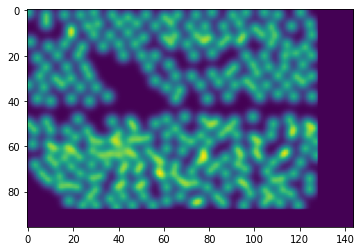

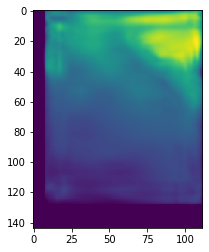

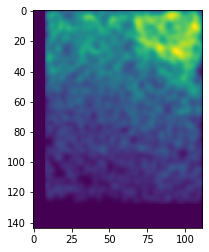

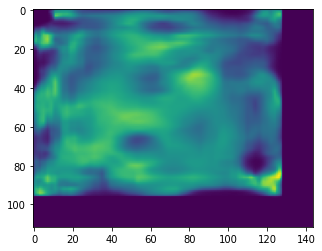

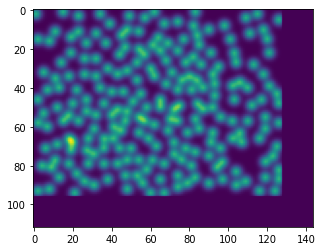

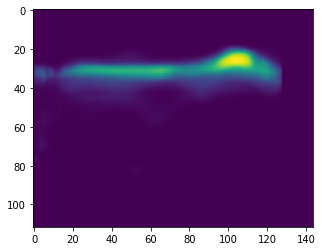

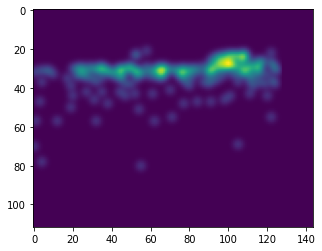

In [133]:
#Loading random inputs and compare the model output with the original image
ii = 0
for epoch in range(1):  # loop over the dataset multiple times
      for pic in AE_dataloader:
        predicted = model(pic)
        plt.imshow(predicted[0].cpu().detach().numpy()[0])
        plt.show()
        plt.imshow(pic[0][0])
        plt.show()
        if ii == 5:
            break
        ii += 1

In [137]:
import torch.utils.benchmark as benchmark
x = torch.randn(1000000, 64)

def batched_dot_mul_sum(a, b):
    '''Computes batched dot by multiplying and summing'''
    return a.mul(b).sum(-1)


def batched_dot_bmm(a, b):
    '''Computes batched dot by reducing to bmm'''
    a = a.reshape(-1, 1, a.shape[-1])
    b = b.reshape(-1, b.shape[-1], 1)
    return torch.bmm(a, b).flatten(-3)
t0 = benchmark.Timer(
    stmt='batched_dot_mul_sum(x, x)',
    setup='from __main__ import batched_dot_mul_sum',
    globals={'x': x})

t1 = benchmark.Timer(
    stmt='batched_dot_bmm(x, x)',
    setup='from __main__ import batched_dot_bmm',
    globals={'x': x})

print(t0.timeit(100))
print(t1.timeit(100))

batched_dot_mul_sum(x, x)
  165.90 ms
  1 measurement, 100 runs , 1 thread
batched_dot_bmm(x, x)
  122.47 ms
  1 measurement, 100 runs , 1 thread
